# TableNet

## Core Idea
If convolutional filters utilized to detect tables, can be reinforced by column detecting filters, this should significantly improve the performance of the model. TableNet model, exploits this intuition and is based on the encoderdecoder model for semantic segmentation. 

The encoder of the model is common across both tasks, but the decoder emerges as two different branches for tables and columns. Concretely, we enforced the encoding layers to use the ground truth of both tables and columns of document for training. However, the decoding layers are separated for table and column branches.

## Architecture

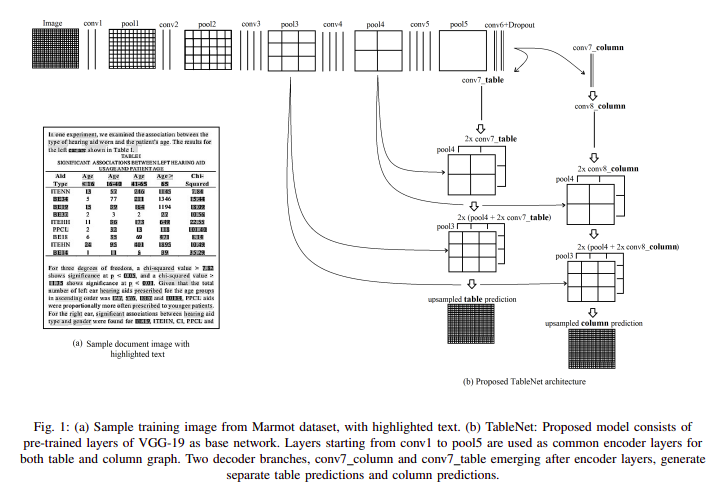

The input image for the model, is first transformed into an RGB image and then, resized to 1024 * 1024 resolution.

Since a single model produces both the output masks for the table and column regions, these two independent outputs have binary target pixel values, depending on whether the pixel region belongs to the table/column region or background respectively.

TableNet model uses the same intuition for the encoder/decoder network as the FCN architecture. It uses a pre-trained VGG-19 layer as the base network. The fully connected layers (layers after pool5) of VGG-19 are replaced with two (1x1) convolution layers. 

Each of these convolution layers (conv6) uses the ReLU activation followed by a dropout layer having probability of 0.8. Following this layer, two different branches of the decoder network are appended.

The output of the (conv6 + dropout) layer is distributed to both decoder branches. In each branch, additional layers are appended to filter out the respective active regions. 

In the table branch of the decoder network, an additional (1x1) convolution layer, conv7 table is used, before using a series of fractionally strided convolution layers for upscaling the image. The output of the conv7 table layer is also up-scaled using fractionally strided convolutions, and is appended with the pool4 pooling layer of the same dimension.

Similarly, the combined feature map is again up-scaled and the pool3 pooling is appended to it. Finally, the final feature map is upscaled to meet the original image dimension. 

In the other branch for detecting columns, there is an additional convolution layer (conv7 column) with a ReLU activation function and a dropout layer with the same dropout probability. The feature maps are up-sampled using fractionally strided convolutions after a (1x1) convolution (conv8 column) layer.

The up-sampled feature maps are combined with the pool4 pooling layer and the combined feature map is up-sampled and combined with the pool3 pooling layer of the same dimension. After this layer, the feature map is up-scaled to the original image. 

In both branches, multiple (1x1) convolution layers are used before the transposed layers. The intuition behind using (1x1) convolution is to reduce the dimensions of feature maps (channels) which is used in class prediction of pixels, since the output layers (output of encoder network) must have channels equal to the number of classes (channel with max probability is assigned to corresponding pixels) which is later up-sampled.

Therefore, the outputs of the two branches of computational graphs yield the mask for the table and column regions.

## Table Row Extraction
After processing the documents using TableNet, masks for table and column regions are generated. These masks are used to filter out the table and its column regions from the image.

Since, all word positions of the document can be known (using Tesseract OCR), only the word patches lying inside table and column regions are filtered out. Now, using these filtered words, a row can be defined as the collection of words from multiple columns, which are at the similar horizontal level. 

However, a row is not necessarily confined to a single line, and depending upon the content of a column or line demarcations, a row can span multiple lines. Therefore, to cover the different possibilities, tha authors have formulated three rules for row segmentation:
* In most tables for which line demarcations are present, the lines segment the rows in each column. To detect the possible line demarcation (for rows), every space between two vertically placed words in a column is tested for the presence of lines via a Radon transform. The presence of horizontal line demarcation clearly segments out the row.
* In case a row spans multiple lines, the rows of the table which have maximum non-blank entries is marked as the starting point for a new row. For example in a multicolumn table, some of the columns can have entries spanning just one line (like quantity, etc), while others can have multi-line entries (like description, etc). Thus, each new row begins when all the entities in each column are filled.
* In tables, where all the columns are completely filled and there are no line demarcations, each line (level) can be seen as a unique row.

## Training 
For training TableNet model, the Marmot table recognition dataset is used. This is the largest publicly available dataset for table detection.

## Paper
TableNet: Deep Learning model for end-to-end Table detection and Tabular data extraction from Scanned Document Images: [2001.01469](https://arxiv.org/abs/2001.01469)

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    BatchNormalization, Conv2D, MaxPooling2D, Activation,  Dropout,  Lambda,  Dense, Flatten, Input, 
    Concatenate, UpSampling2D
)

# Data Preparation

In [2]:
!cp ../input/marmot-dataset/data data --recursive
!cp ../input/marmot-dataset/generate_mask.py generate_mask.py 
!mkdir table_mask column_mask
!python generate_mask.py

In [3]:
list_ds = tf.data.Dataset.list_files('data/*.xml')

2022-07-19 12:20:19.248930: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-19 12:20:19.359078: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-19 12:20:19.359934: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-19 12:20:19.367186: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [4]:
img_height, img_width, img_channels = 1024, 1024, 3

def normalize(input_image):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image


def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img)
    # resize the image to the desired size
    return tf.image.resize(img, [img_height, img_width])

def decode_mask_img(img):
    # convert the compressed string to a 2D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=1)
    # resize the image to the desired size
    return tf.image.resize(img, [img_height, img_width])


def process_path(file_path):
    file_path = tf.strings.regex_replace(file_path, '.xml', '.jpeg')
    table_mask_file_path = tf.strings.regex_replace(file_path, 'data', 'table_mask')
    column_mask_file_path = tf.strings.regex_replace(file_path, 'data', 'column_mask')
    img = normalize(decode_img(tf.io.read_file(file_path)))
    table_mask = normalize(decode_mask_img(tf.io.read_file(table_mask_file_path)))
    column_mask = normalize(decode_mask_img(tf.io.read_file(column_mask_file_path)))
    
    return img, {"table_output" : table_mask, "column_output" : column_mask }

In [5]:
DATASET_SIZE = len(list(list_ds))
train_size = int(0.9 * DATASET_SIZE)
test_size = int(0.1 * DATASET_SIZE)

train = list_ds.take(train_size)
test = list_ds.skip(train_size)

TRAIN_LENGTH = len(list(train))
BATCH_SIZE = 2
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

train = train.shuffle(BUFFER_SIZE)
train = train.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train.batch(BATCH_SIZE).repeat().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

test = test.map(process_path)
test_dataset = test.batch(BATCH_SIZE)

In [6]:
def display(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'Table Mask', 'Column Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

2022-07-19 12:20:22.768215: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


(1024, 1024, 3)


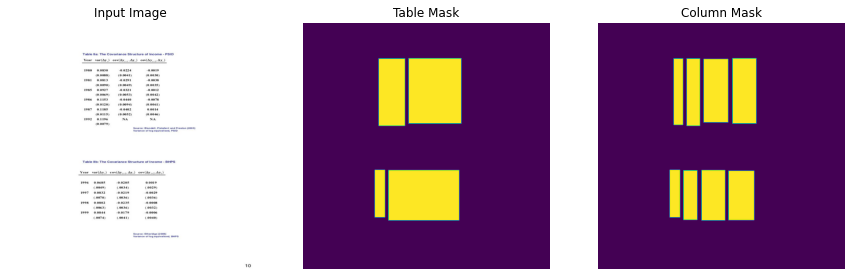

(1024, 1024, 3)


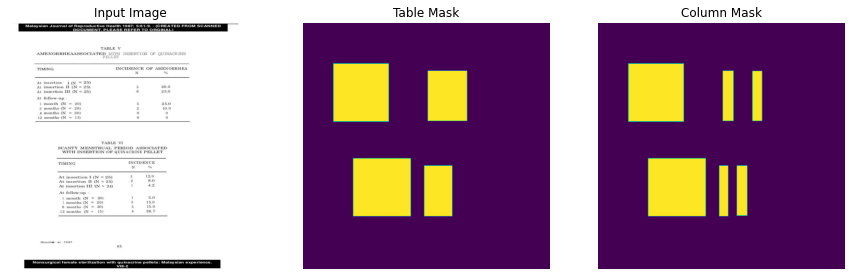

In [7]:
for image, mask  in train.take(2):
    print(image.shape)
    display([image, mask['table_output'], mask['column_output']])

# Build the Model

In [8]:
class TableNet:
    @staticmethod
    def build_table_decoder(inputs, pool3, pool4):
        x = Conv2D(512, (1, 1), activation="relu", name="conv7_table")(inputs)
        x = UpSampling2D(size=(2, 2))(x)

        concatenated = Concatenate()([x, pool4])

        x = UpSampling2D(size=(2, 2))(concatenated)

        concatenated = Concatenate()([x, pool3])

        x = UpSampling2D(size=(2, 2))(concatenated)
        x = UpSampling2D(size=(2, 2))(x)

        last = tf.keras.layers.Conv2DTranspose(3, 3, strides=2, padding="same", name="table_output")

        x = last(x)

        return x

    @staticmethod
    def build_column_decoder(inputs, pool3, pool4):

        x = Conv2D(512, (1, 1), activation="relu", name="block7_conv1_column")(inputs)
        x = Dropout(0.8, name="block7_dropout_column")(x)

        x = Conv2D(512, (1, 1), activation="relu", name="block8_conv1_column")(x)
        x = UpSampling2D(size=(2, 2))(x)

        concatenated = Concatenate()([x, pool4])

        x = UpSampling2D(size=(2, 2))(concatenated)

        concatenated = Concatenate()([x, pool3])

        x = UpSampling2D(size=(2, 2))(concatenated)
        x = UpSampling2D(size=(2, 2))(x)

        last = tf.keras.layers.Conv2DTranspose(3, 3, strides=2, padding="same", name="column_output")

        x = last(x)

        return x

    @staticmethod
    def vgg_base(inputs):
        base_model = tf.keras.applications.vgg19.VGG19(
            input_shape=[img_height, img_width, img_channels], include_top=False, weights="imagenet"
        )

        layer_names = ["block3_pool", "block4_pool", "block5_pool"]
        layers = [base_model.get_layer(name).output for name in layer_names]

        pool_layers_model = Model(inputs=base_model.input, outputs=layers, name="VGG-19")
        pool_layers_model.trainable = False

        return pool_layers_model(inputs)

    @staticmethod
    def build():
        inputShape = (img_height, img_width, img_channels)

        inputs = Input(shape=inputShape, name="input")

        pool_layers = TableNet.vgg_base(inputs)

        x = Conv2D(512, (1, 1), activation="relu", name="block6_conv1")(pool_layers[2])
        x = Dropout(0.8, name="block6_dropout1")(x)
        x = Conv2D(512, (1, 1), activation="relu", name="block6_conv2")(x)
        x = Dropout(0.8, name="block6_dropout2")(x)

        table_mask = TableNet.build_table_decoder(x, pool_layers[0], pool_layers[1])
        column_mask = TableNet.build_column_decoder(x, pool_layers[0], pool_layers[1])

        model = Model(inputs=inputs, outputs=[table_mask, column_mask], name="tablenet")

        return model

80150528/80134624 [==============================] - 0s 0us/step


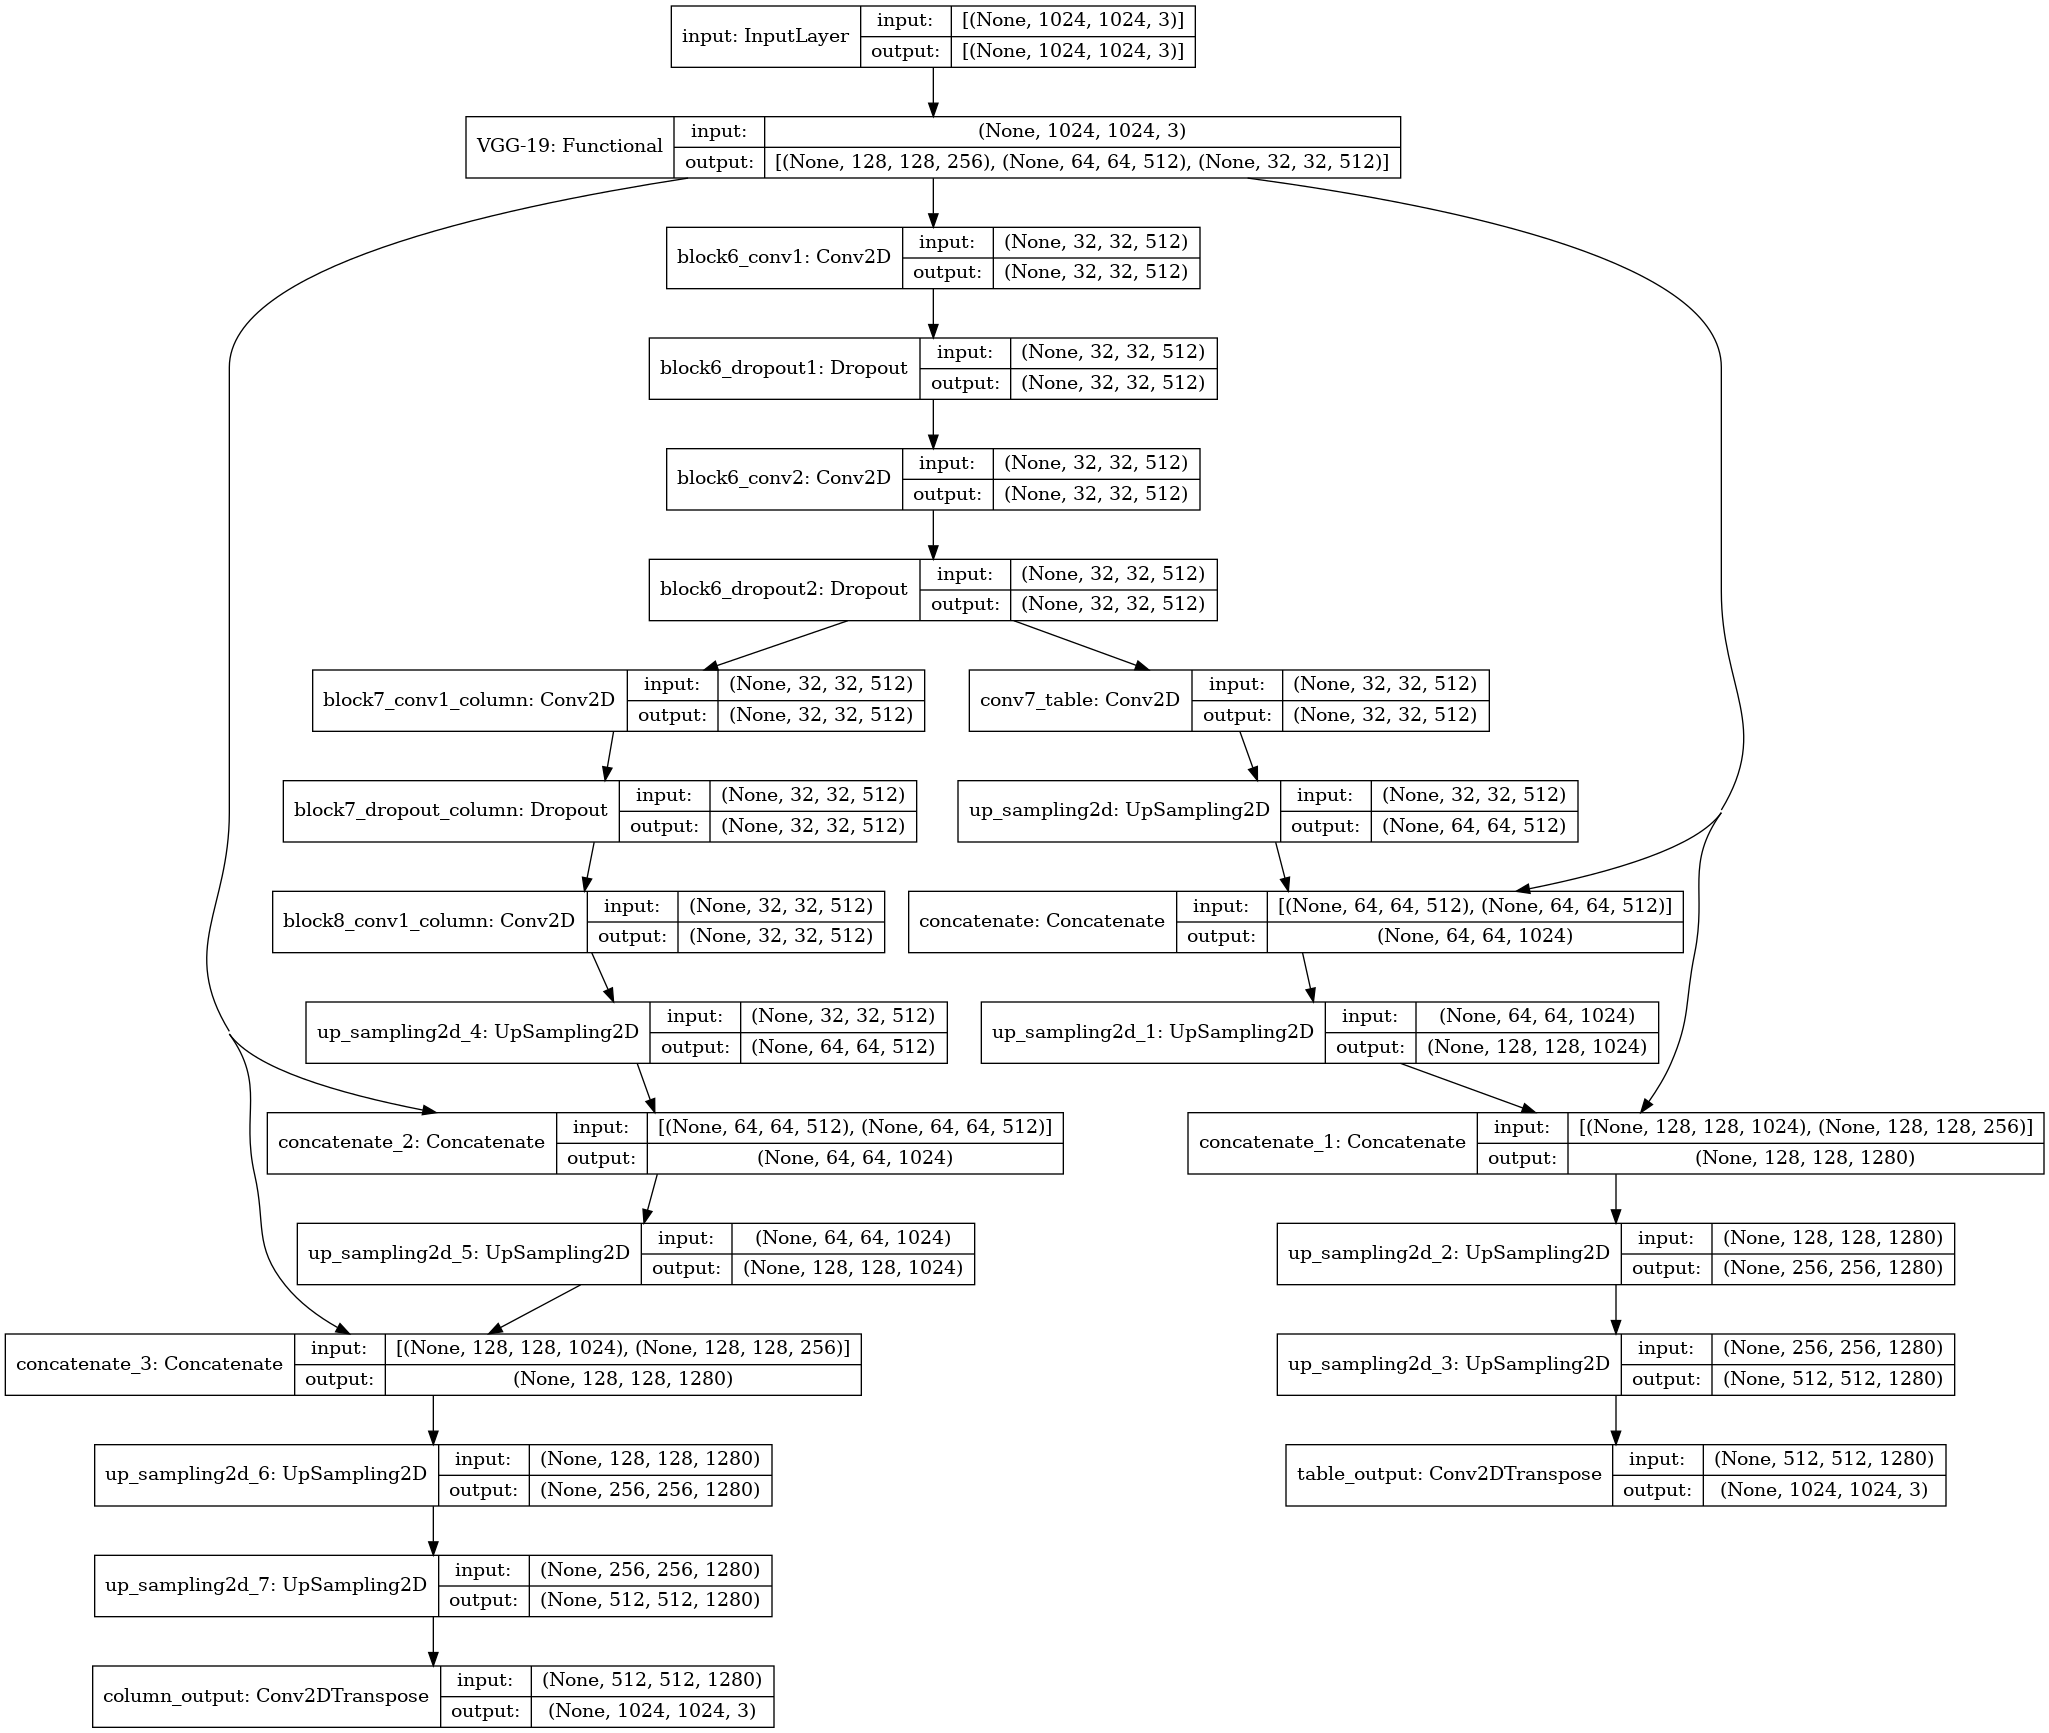

In [9]:
model = TableNet.build()
tf.keras.utils.plot_model(model, show_shapes=True)

# Traning

In [10]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    loss={
        "table_output": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        "column_output": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    },
    metrics=['accuracy'],
    loss_weights={"table_output": 1.0, "column_output": 1.0}
)

In [11]:
def create_mask(pred_mask1, pred_mask2):
    pred_mask1 = tf.argmax(pred_mask1, axis=-1)
    pred_mask1 = pred_mask1[..., tf.newaxis]


    pred_mask2 = tf.argmax(pred_mask2, axis=-1)
    pred_mask2 = pred_mask2[..., tf.newaxis]
    return pred_mask1[0], pred_mask2[0]


In [12]:
for image, mask in train_dataset.take(1):
    sample_image, sample_mask1, sample_mask2 = image, mask['table_output'], mask['column_output']

def show_predictions(dataset=None, num=1):
    if dataset:
        for image, (mask1, mask2) in dataset.take(num):
            pred_mask1, pred_mask2 = model.predict(image, verbose=1)
            table_mask, column_mask = create_mask(pred_mask1, pred_mask2)
            display([image[0], table_mask, column_mask])
    else:
        pred_mask1, pred_mask2 = model.predict(sample_image, verbose=1)
        table_mask, column_mask = create_mask(pred_mask1, pred_mask2)
        display([sample_image[0], table_mask, column_mask])

2022-07-19 12:20:29.292657: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1/1 [==============================] - 12s 12s/step


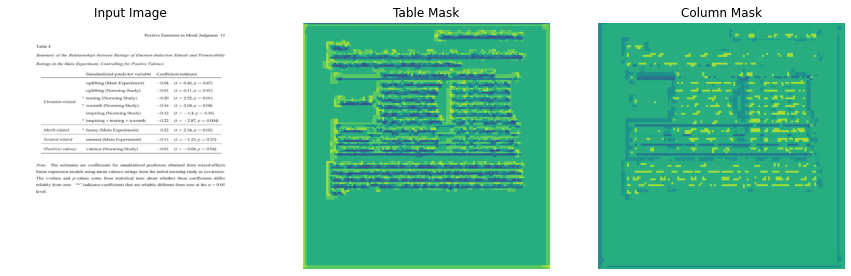

In [13]:
show_predictions()

In [14]:
from IPython.display import clear_output

class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print (f'\nSample Prediction after epoch {epoch+1}\n')

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "model_{epoch:04}", save_best_only=True, monitor="val_loss", verbose=1
)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(patience=5, verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, verbose=1)

csv_logger = tf.keras.callbacks.CSVLogger("model.csv")


1/1 [==============================] - 0s 26ms/step


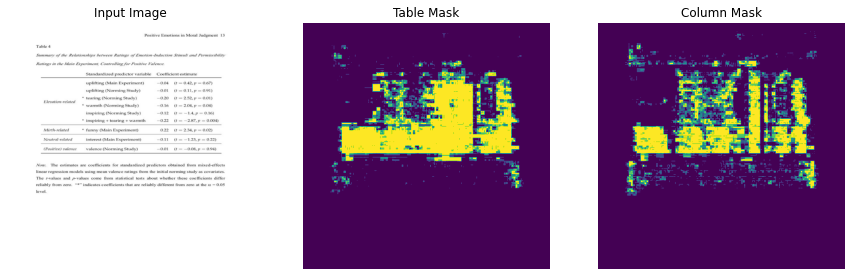


Sample Prediction after epoch 42


Epoch 00042: val_loss did not improve from 0.22014

Epoch 00042: ReduceLROnPlateau reducing learning rate to 5.000000413701855e-10.
Epoch 00042: early stopping


In [15]:
EPOCHS = 5000
VAL_SUBSPLITS = 5
VALIDATION_STEPS = test_size//BATCH_SIZE//VAL_SUBSPLITS


model_history = model.fit(
    train_dataset, epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    validation_data=test_dataset,
    callbacks=[DisplayCallback(), model_checkpoint, early_stopping, csv_logger, reduce_lr]
)

1/1 [==============================] - 0s 26ms/step


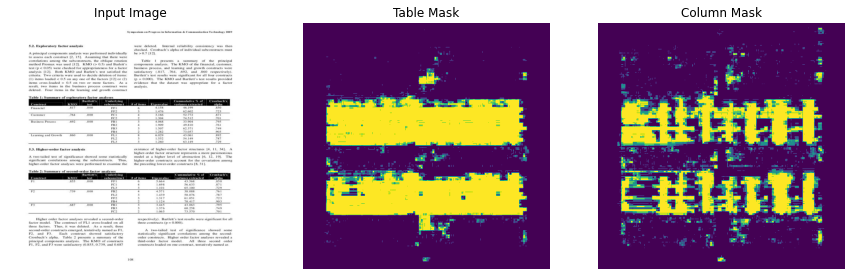

1/1 [==============================] - 0s 28ms/step


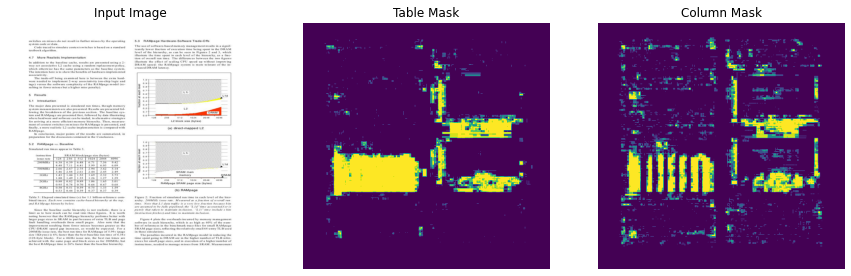

1/1 [==============================] - 0s 40ms/step


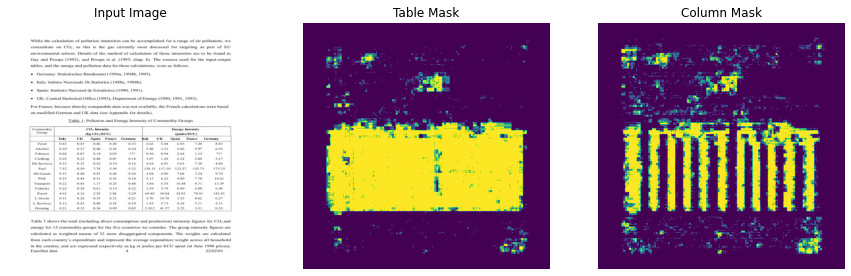

1/1 [==============================] - 0s 27ms/step


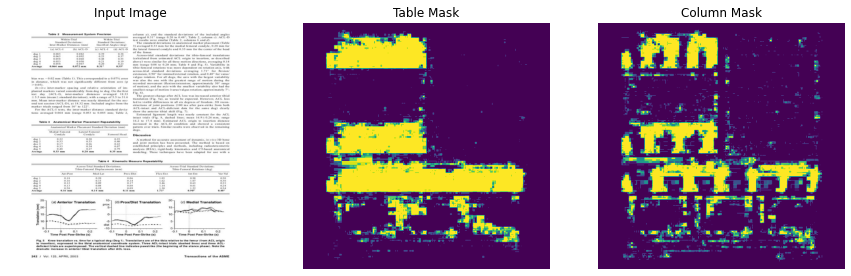

1/1 [==============================] - 0s 31ms/step


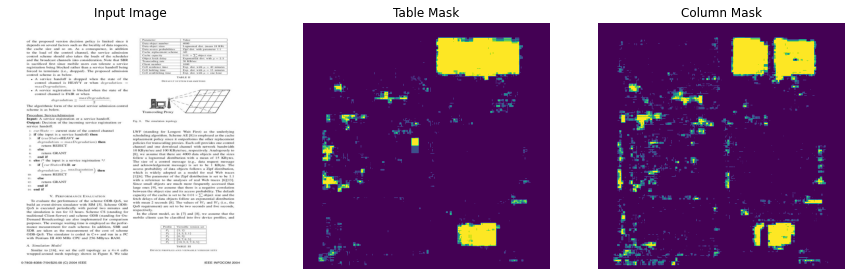

In [16]:
show_predictions(train_dataset, 5)

In [17]:
model.save('tablenet_model')